In [1]:
import pandas as pd
import numpy as np
import os
import sys
from scipy import sparse
import tqdm
from sklearn.metrics import *
import joblib

In [2]:
sys.path.insert(0,"../")
import warnings
warnings.filterwarnings("ignore")
import os
import argparse
import pandas as pd

import torch.nn as nn
from torch.optim import Adam

from dkt import DKT
from utils.logger import Logger
from utils.metrics import Metrics
from utils.misc import *

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class DKT(nn.Module):
    def __init__(self, num_items, embed_inputs, embed_size, hid_size, num_hid_layers, drop_prob):
        """Deep knowledge tracing.
        
        Arguments:
            num_items (int): Number of items
            embed_inputs (bool): If True embed inputs, else one hot encoding
            embed_size (int): Input embedding dimension
            hid_size (int): Hidden layer dimension
            num_hid_layers (int): Number of hidden layers
            drop_prob (float): Dropout probability
        """
        super(DKT, self).__init__()
        self.num_items = num_items
        self.embed_inputs = embed_inputs

        if self.embed_inputs:
            self.input_embeds = nn.Embedding(2 * num_items + 1, embed_size, padding_idx=0)
            self.input_embeds.weight.requires_grad = True
            self.lstm = nn.LSTM(embed_size, hid_size, num_hid_layers)
        else:
            self.lstm = nn.LSTM(2 * num_items + 1, hid_size, num_hid_layers)
        
        self.dropout = nn.Dropout(p=drop_prob)
        self.out =   nn.Linear(hid_size, num_items)

    def forward(self, inputs, hidden=None):
        if self.embed_inputs:
            embeds = self.input_embeds(inputs)
        else:
            embeds = F.one_hot(inputs, 2 * self.num_items + 1).float()
            
        out, hidden = self.lstm(embeds, hx=hidden)
        return self.out(self.dropout(out)), hidden
    
    def repackage_hidden(self, hidden, length):

        return tuple((v[:, -length:].detach().contiguous() for v in hidden))

In [3]:
dt= {
 'correctness': 'int64',
 'user_id':'int64',
 'concept_code': "str",
      "attempt_created_at":"int64"  
}

In [4]:
!ls ../../../new_dkt_data

train_df.csv  val_df.csv


In [5]:

train_df = pd.read_csv('../../../new_dkt_data/train_df.csv',usecols=["user_id","concept_code","correctness","attempt_created_at"],dtype=dt)
valid_df = pd.read_csv('../../../new_dkt_data/val_df.csv',usecols=["user_id","concept_code","correctness","attempt_created_at"],dtype=dt)


In [6]:
train_df.isna().sum()

correctness           0
user_id               0
attempt_created_at    0
concept_code          0
dtype: int64

In [8]:
train_df.shape , valid_df.shape

((67006058, 4), (28670930, 4))

In [9]:
train_df=train_df.rename(columns={"correctness":"correct"})
valid_df=valid_df.rename(columns={"correctness":"correct"})

In [10]:
train_df["skill_id"]  = pd.factorize(train_df['concept_code'], sort=True)[0]

In [11]:
label_stoi = dict(zip(train_df.concept_code.tolist(),train_df.skill_id.tolist()))
                  

In [12]:
joblib.dump(label_stoi,"./models/label_stoi.pkl")

['./models/label_stoi.pkl']

In [13]:
train_df.shape, valid_df.shape,len(label_stoi)

((67006058, 5), (28670930, 4), 12857)

In [14]:
valid_df["skill_id"] =  valid_df.concept_code.map(label_stoi)

In [15]:
train_df.skill_id.nunique(),valid_df.skill_id.nunique()

(12857, 12567)

In [16]:
valid_df[valid_df.skill_id.isin(train_df.skill_id.unique())].shape


(28670930, 5)

In [17]:
num_items = int(train_df["skill_id"].max() + 1)
print(num_items)

12857


In [18]:
num_items = num_items + 12143
num_items

25000

In [19]:
SEED = 4
embed_inputs =True
drop_prob =0.3
batch_size = 16
embed_size=200
hid_size=100
num_hid_layers=1
num_epochs=3


In [20]:
model = DKT(num_items, embed_inputs=embed_inputs, embed_size =embed_size,hid_size=hid_size,
            num_hid_layers = num_hid_layers, drop_prob=drop_prob).cuda()

optimizer = Adam(model.parameters(), lr=8e-4)

In [21]:
param_str = (f'dkt_train')
logger = Logger(os.path.join(".", param_str))


In [22]:
train_df.skill_id.nunique()

12857

In [23]:
model

DKT(
  (input_embeds): Embedding(50001, 200, padding_idx=0)
  (lstm): LSTM(200, 100)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=100, out_features=25000, bias=True)
)

In [2]:
(2 + 1*25000 +1), (2 + 0*25000 +1)

(25003, 3)

In [27]:
def get_data(df, train_split=0.7):
    num_items = 25_000  #df["skill_id"].nunique() #itme_id
    data = [(torch.tensor(u_df["skill_id"].values, dtype=torch.long),
             torch.tensor(u_df["correct"].values, dtype=torch.long),
             user_id )
            for user_id, u_df in tqdm.tqdm_notebook(df.groupby("user_id"))]

    data = [(torch.cat((torch.zeros(1, dtype=torch.long), item_ids + labels * num_items + 1))[:-1], item_ids, labels,user_id)
            for (item_ids, labels, user_id) in tqdm.tqdm_notebook(data)]

#     np.random.seed(SEED)
#     np.random.shuffle(data)
        
    return data


In [28]:
def prepare_batches(data, batch_size):
    """Prepare batches grouping padded sequences.
    
    Arguments:
        data (list of tuples of torch Tensor)
        batch_size (int): number of sequences per batch
        
    Output:
        batches (list of tuples of torch Tensor)
    """
    shuffle(data)
    batches = []

    for k in tqdm.tqdm_notebook(range(0, len(data), batch_size)):
        batch = data[k:k + batch_size]
        np.random.seed(SEED)
        np.random.shuffle(batch)
        inputs, item_ids, labels,user_id = zip(*batch)

        inputs = pad_sequence(inputs, batch_first=True, padding_value=0)     # Pad with 0
        item_ids = pad_sequence(item_ids, batch_first=True, padding_value=0) # Don't care
        labels = pad_sequence(labels, batch_first=True, padding_value=-1)    # Pad with -1

        batches.append([inputs, item_ids, labels])
        
    return batches


In [29]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=2, gamma=0.96)

In [30]:
train_data, val_data = get_data(train_df),get_data(valid_df)
criterion = nn.BCEWithLogitsLoss(reduction="sum")
metrics = Metrics()
step = 0




In [31]:
batch_size = 8
train_batches = prepare_batches(train_data, batch_size)
val_batches = prepare_batches(val_data, batch_size)


In [32]:
model

DKT(
  (input_embeds): Embedding(50001, 200, padding_idx=0)
  (lstm): LSTM(200, 100)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=100, out_features=25000, bias=True)
)

In [ ]:
def compute_loss(preds, item_ids, labels, criterion):
    labels = labels.view(-1)
    item_ids = item_ids.view(-1)[labels >= 0]
    preds = preds.view(-1, preds.shape[-1])[labels >= 0]
    preds = preds[torch.arange(preds.shape[0]), item_ids]
    labels = labels[labels >= 0].float()
    return criterion(preds, labels)

In [33]:
def compute_auc(preds, item_ids, labels,is_train=False):
    labels = labels.view(-1)
    item_ids = item_ids.view(-1)[labels >= 0]
    preds = preds.view(-1, preds.shape[-1])[labels >= 0]
    preds = preds[torch.arange(preds.shape[0]), item_ids]
    labels = labels[labels >= 0].float()

    if len(torch.unique(labels)) == 1: 
        auc = accuracy_score(labels, preds.round())
    else:
        auc = roc_auc_score(labels, preds)
        if is_train==False :
            precision,recall=precision_score(labels,preds.round()) , recall_score(labels,preds.round())
            acc =accuracy_score(labels, preds.round())
            return auc , precision,recall , acc
    return auc 




In [34]:
import torch

In [35]:
len(train_batches),len(val_batches)

(56441, 24171)

In [36]:
low_gpu_mem=False
val_step=0

In [37]:
num_epochs =3

In [38]:
for epoch in tqdm.tqdm_notebook(range(num_epochs)):

    print(f"Training EPOCH {epoch}")
    model.train()
    for inputs, item_ids, labels in tqdm.tqdm_notebook(train_batches):
        batch_size, length = inputs.shape
        preds = torch.zeros(batch_size, length, model.num_items)

        # Put sequence on gpu by chunks (low gpu memory usage, slow)
        inputs, preds = inputs.cuda(), preds.cuda()

        preds , hidden = model(inputs)

        loss = compute_loss(preds, item_ids.cuda(), labels.cuda(), criterion)
        preds = preds.detach().cpu()

        loss /= labels[labels >= 0].sum()
        
        preds = torch.sigmoid(preds)
        train_auc= compute_auc(preds, item_ids, labels,True)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1
        metrics.store({'loss/train': loss.item()})
        metrics.store({'auc/train': train_auc})
        
        
        if step % 4000 == 0:
            print(f"Train AUC :{metrics.average()}")
        
        # Logging
        if step % 56441 == 0:
            logger.log_scalars(metrics.average(), step)
            weights = {"weight/" + name: param for name, param in model.named_parameters()}
            grads = {"grad/" + name: param.grad
                     for name, param in model.named_parameters() if param.grad is not None}
            logger.log_histograms(weights, step)
            logger.log_histograms(grads, step)
    scheduler.step()
    
    print(f"Validation EPOCH {epoch}")
    # Validation
    model.eval()
    mean_val_auc = []
    mean_val_precision = []
    mean_val_recall = []
    mean_val_acc = []
    for inputs, item_ids, labels in tqdm.tqdm_notebook(val_batches):
        batch_size, length = inputs.shape

        with torch.no_grad():
            if low_gpu_mem:
                preds = torch.zeros(batch_size, length, model.num_items)
                for i in range(0, length, bptt):
                    inp = inputs[:, i:i + bptt].cuda()
                    if i == 0:
                        pred, hidden = model(inp)
                    else:
                        hidden = model.repackage_hidden(hidden, inp.shape[1])
                        pred, hidden = model(inp, hidden)
                    preds[:, i:i + bptt] = torch.sigmoid(pred).cpu()

            else:
                inputs = inputs.cuda()
                preds, _ = model(inputs)
                preds = torch.sigmoid(preds).cpu()

        val_auc,precision,recall,acc = compute_auc(preds, item_ids, labels)
        val_step += 1
        metrics.store({'auc/val': val_auc})
        mean_val_auc.append(val_auc)
        mean_val_precision.append(precision)
        mean_val_recall.append(recall)
        mean_val_acc.append(acc)
        
        if val_step % 1000 == 0:
            print(f"valid AUC :{metrics.average()}")
        
        if val_step % 24171 == 0:
            logger.log_scalars(metrics.average(), val_step)



    print("VAL_AUc : ", np.mean(mean_val_auc))
    print("VAL_Precision : ", np.mean(mean_val_precision))
    print("VAL_Recall : ", np.mean(mean_val_recall))
    print("VAL_Accuracy : ", np.mean(mean_val_acc))



    torch.save(model.state_dict(),f"./models/dkt_ep{epoch}.pth")

    model.train()




Training EPOCH 0


Train AUC :{'loss/train': 0.986699049025774, 'auc/train': 0.819346057927364}
Train AUC :{'loss/train': 0.858167714715004, 'auc/train': 0.8660947713960686}
Train AUC :{'loss/train': 0.8345437209755182, 'auc/train': 0.8739560734543806}
Train AUC :{'loss/train': 0.817573717996478, 'auc/train': 0.8770339913761936}
Train AUC :{'loss/train': 0.8164505609795452, 'auc/train': 0.8794500650712258}
Train AUC :{'loss/train': 0.8101481848061085, 'auc/train': 0.8804521911034051}
Train AUC :{'loss/train': 0.8049712811782956, 'auc/train': 0.8821720617845178}
Train AUC :{'loss/train': 0.8005988025739789, 'auc/train': 0.8825551646782631}
Train AUC :{'loss/train': 0.8011181055158376, 'auc/train': 0.8831735622217598}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

valid AUC :{'auc/val': 0.8896927611610328}
valid AUC :{'auc/val': 0.8896242242715109}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8893500651472821}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8897757740005677}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.889815113447206}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8895891857947898}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8899643304583451}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8889814729207748}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8888082833160954}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step 24171, {'auc/val': 0.8883185144758875}

VAL_AUc :  0.8898389147007302
VAL_Precision :  0.7921058430542556
VAL_Recall :  0.7909551138246458
VAL_Accuracy :  0.7897413075105733
Training EPOCH 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7760678517429908, 'auc/train': 0.888273639458748}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Train AUC :{'loss/train': 0.7746499199047685, 'auc/train': 0.8896855637516834}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7744416362792254, 'auc/train': 0.8893418110053095}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7734892397820949, 'auc/train': 0.8905907684429115}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7724037717059254, 'auc/train': 0.8903581234195809}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7709343087747693, 'auc/train': 0.890972606432188}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Step 112882, {'loss/train': 0.7678928200214629, 'auc/train': 0.8909574688476931}

Validation EPOCH 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8917254416590118}
valid AUC :{'auc/val': 0.8926462754077436}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.891853825601126}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8920274676067572}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8925661608252347}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8923275222902001}
valid AUC :{'auc/val': 0.8920810242632737}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid AUC :{'auc/val': 0.8924718098870447}
valid AUC :{'auc/val': 0.892772059558922}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Train AUC :{'loss/train': 0.7586457451060414, 'auc/train': 0.8932883452422373}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7600028618425131, 'auc/train': 0.8934869526654843}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7605497772023082, 'auc/train': 0.8934843817376357}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7633199166655541, 'auc/train': 0.8938883841390021}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7619163524955511, 'auc/train': 0.8938995488594305}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.761210349239409, 'auc/train': 0.8937274397130954}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7603636064231396, 'auc/train': 0.8942824977269076}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train AUC :{'loss/train': 0.7647357620075345, 'auc/train': 0.8937500413982161}
Train AUC :{'loss/train': 0.7599017933309078, 'auc/train': 0.8939195864398797}
Train AUC :{'loss/train': 0.7598827985674143, 'auc/train': 0.8941857376869524}
Train AUC :{'loss/train': 0.7591406706497074, 'auc/train': 0.8948059780480928}
Step 169323, {'loss/train': 0.7592719424113304, 'auc/train': 0.8941764830468805}

Validation EPOCH 2


valid AUC :{'auc/val': 0.8926597135306374}
valid AUC :{'auc/val': 0.8929010176100313}
valid AUC :{'auc/val': 0.8930790810130427}
valid AUC :{'auc/val': 0.8934624601422613}
valid AUC :{'auc/val': 0.8921758750141373}
valid AUC :{'auc/val': 0.8918848657360566}
valid AUC :{'auc/val': 0.8924569192368268}
valid AUC :{'auc/val': 0.8924406539479769}
valid AUC :{'auc/val': 0.8928345700357242}
valid AUC :{'auc/val': 0.8949322419202587}
valid AUC :{'auc/val': 0.8936901627946354}
valid AUC :{'auc/val': 0.89342422659965}
valid AUC :{'auc/val': 0.8934182316449574}
valid AUC :{'auc/val': 0.8927087688148666}
valid AUC :{'auc/val': 0.8931866119002955}
valid AUC :{'auc/val': 0.8937530006136323}
valid AUC :{'auc/val': 0.8930287304690844}
valid AUC :{'auc/val': 0.892626687162633}
valid AUC :{'auc/val': 0.8921762969681989}
valid AUC :{'auc/val': 0.8928200654062328}
valid AUC :{'auc/val': 0.8938520130348643}
valid AUC :{'auc/val': 0.8934331732949656}
valid AUC :{'auc/val': 0.8926935823042179}
valid AUC :{'a

In [40]:

    print("VAL_AUc : ", np.mean(mean_val_auc))
    print("VAL_Precision : ", np.mean(mean_val_precision))
    print("VAL_Recall : ", np.mean(mean_val_recall))
    print("VAL_Accuracy : ", np.mean(mean_val_acc))


VAL_AUc :  0.8930427271406398
VAL_Precision :  0.7953160140486687
VAL_Recall :  0.7949622491910293
VAL_Accuracy :  0.7934275078843777


In [41]:
model

DKT(
  (input_embeds): Embedding(50001, 200, padding_idx=0)
  (lstm): LSTM(200, 100)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=100, out_features=25000, bias=True)
)

In [ ]:
VAL_AUc :  0.8930427271406398
VAL_Precision :  0.7953160140486687
VAL_Recall :  0.7949622491910293
VAL_Accuracy :  0.7934275078843777

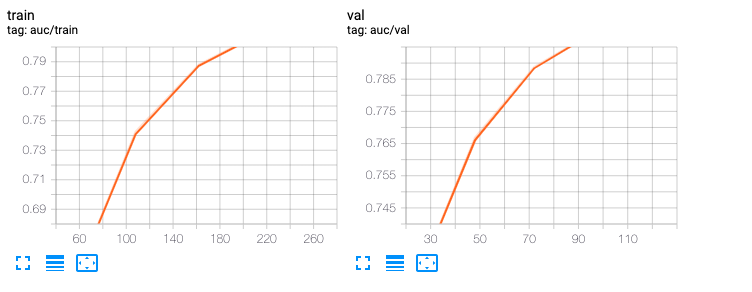

In [46]:
    print("VAL_AUc : ", np.mean(mean_val_auc))
    print("VAL_Precision : ", np.mean(mean_val_precision))
    print("VAL_Recall : ", np.mean(mean_val_recall))
    print("VAL_Accuracy : ", np.mean(mean_val_acc))


VAL_AUc :  0.6875395504601222
VAL_Precision :  0.7842745870902358
VAL_Recall :  0.6308461817487193
VAL_Accuracy :  0.6360258579305346


In [53]:
from sklearn.metrics import auc as AUC


In [56]:
def compute_auc(preds, item_ids, labels,is_train=False):
    labels = labels.view(-1)
    item_ids = item_ids.view(-1)[labels >= 0]
    preds = preds.view(-1, preds.shape[-1])[labels >= 0]
    preds = preds[torch.arange(preds.shape[0]), item_ids]
    labels = labels[labels >= 0].float()

    if len(torch.unique(labels)) == 1: 
        auc = accuracy_score(labels, preds.round())
    else:
        auc = roc_auc_score(labels, preds)
        if is_train==False :
            precision,recall=precision_score(labels,preds.round()) , recall_score(labels,preds.round())
            acc =accuracy_score(labels, preds.round())
            return auc , precision,recall , acc
    return auc 




In [57]:
        val_auc,precision,recall,acc = compute_auc(preds, item_ids, labels)

In [58]:
val_auc

0.6406704260651629

In [30]:
model.load_state_dict(torch.load("../models/dkt_ep1.pth"))

<All keys matched successfully>

In [31]:
    model.eval()
    mean_val_auc = []
    mean_val_precision = []
    mean_val_recall = []
    mean_val_acc = []
    PREDS = []
    LABELS  =[]
    for inputs, item_ids, labels in tqdm.tqdm_notebook(val_batches):
        batch_size, length = inputs.shape

        with torch.no_grad():
            if low_gpu_mem:
                preds = torch.zeros(batch_size, length, model.num_items)
                for i in range(0, length, bptt):
                    inp = inputs[:, i:i + bptt].cuda()
                    if i == 0:
                        pred, hidden = model(inp)
                    else:
                        hidden = model.repackage_hidden(hidden, inp.shape[1])
                        pred, hidden = model(inp, hidden)
                    preds[:, i:i + bptt] = torch.sigmoid(pred).cpu()

            else:
                inputs = inputs.cuda()
                preds, _ = model(inputs)
                preds = torch.sigmoid(preds).cpu()
#         PREDS.append(preds)
#         LABELS.append(labels)        
        val_auc,precision,recall,acc = compute_auc(preds, item_ids, labels)
        val_step += 1
        metrics.store({'auc/val': val_auc})
        mean_val_auc.append(val_auc)
        mean_val_precision.append(precision)
        mean_val_recall.append(recall)
        mean_val_acc.append(acc)
        
        if val_step % 500 == 0:
            print(f"valid AUC :{metrics.average()}")
        
        if val_step % 6043 == 0:
            logger.log_scalars(metrics.average(), val_step)



    print("VAL_AUc : ", np.mean(mean_val_auc))
    print("VAL_Precision : ", np.mean(mean_val_precision))
    print("VAL_Recall : ", np.mean(mean_val_recall))
    print("VAL_Accuracy : ", np.mean(mean_val_acc))





valid AUC :{'auc/val': 0.8098127549450544}
valid AUC :{'auc/val': 0.8093102617479626}
valid AUC :{'auc/val': 0.8085450814784874}
valid AUC :{'auc/val': 0.8103699555464648}
valid AUC :{'auc/val': 0.8098108003828118}
valid AUC :{'auc/val': 0.8110838851150634}
valid AUC :{'auc/val': 0.8113464072223515}
valid AUC :{'auc/val': 0.811074744206544}
valid AUC :{'auc/val': 0.8097759467247325}
valid AUC :{'auc/val': 0.8107178078849437}
valid AUC :{'auc/val': 0.8100975531134752}
valid AUC :{'auc/val': 0.8099224693255874}
Step 6043, {'auc/val': 0.8083207104738939}

VAL_AUc :  0.8101425822268933
VAL_Precision :  0.7644662372840125
VAL_Recall :  0.6203854983102342
VAL_Accuracy :  0.7010121201064257


In [ ]:
# model

In [ ]:
# VAL_AUc :  0.8101425822268933
# VAL_Precision :  0.7644662372840125
# VAL_Recall :  0.6203854983102342
# VAL_Accuracy :  0.7010121201064257